In [1]:
#importing Library

import tensorflow as tf
import numpy as np
import cv2
from imutils.paths import list_images

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
#path for dataset

path=r"C:/Users/Administrator/Desktop/AI/vector/MASKED/dataset"

In [3]:
#assigning size of input image image to 224 * 224 pixels
target_size=(224,224)
dataset=[]

In [4]:
# Inputing images for training

# First of all inputting images of people with mask

for file in list_images(r"C:/Users/Administrator/Desktop/AI/vector/MASKED/dataset/with_mask"):
    image=cv2.imread(file)
    image=cv2.resize(image,target_size)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=tf.keras.applications.mobilenet_v2.preprocess_input(image)
    dataset.append(image)

# Inputting images of peaple without mask
for file in list_images(r"C:/Users/Administrator/Desktop/AI/vector/MASKED/dataset/without_mask"):
    image=cv2.imread(file)
    image=cv2.resize(image,target_size)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=tf.keras.applications.mobilenet_v2.preprocess_input(image)
    dataset.append(image)
    
    

In [5]:
#converting pixel value to numpy array
dataset=np.array(dataset)

In [6]:
dataset.shape

(1375, 224, 224, 3)

In [7]:
#assigning labels to the image, person wearing mask = 1, person not wearing mask = 0

labels=[1.]*690+[0.]*686
labels=np.array([labels]).T

In [8]:
labels.shape

(1376, 1)

In [9]:

#loading mobile visual recognition architecture

mobnet=tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
mobnet.trainable=False

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [10]:

# Adding Extra Layers in MobileNetV2 architecture

mob_net_output=mobnet.output
y=tf.keras.layers.AveragePooling2D(pool_size=(7,7))(mob_net_output)
y=tf.keras.layers.Flatten()(y)
y=tf.keras.layers.Dense(128,activation="relu")(y)
y=tf.keras.layers.Dropout(0.5)(y)
y=tf.keras.layers.Dense(1,activation="sigmoid")(y)



In [11]:
#grouping layers into an object with training and inference features.
fin_mod=tf.keras.models.Model(inputs=mobnet.input,outputs=y)

In [12]:
# Summary of the fin_mod model
fin_mod.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [13]:
import random

In [14]:
indices=np.arange(1375)
random.shuffle(indices)

In [15]:
dataset=dataset[indices,:,:,:]


In [16]:
labels=labels[indices,:]

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
#splitting data in train and test
trainX,testX,trainY,testY=train_test_split(dataset,labels,test_size=0.22,stratify=labels,random_state=42)

In [19]:
#assigning hyperparameters
Epoch=10
batchsize=32
learning_rate=1e-4

In [21]:


opt=tf.keras.optimizers.Adam(lr=learning_rate, decay=learning_rate/Epoch)

fin_mod.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


In [22]:
#artificially expanding the size of a training dataset by creating modified versions of images in the dataset
aug=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                    zoom_range=0.15,
                                                    width_shift_range=0.2,
                                                    height_shift_range=0.2,
                                                    shear_range=0.15,
                                                    horizontal_flip=True,
                                                    fill_mode="nearest")

In [23]:
# Training the data
history=fin_mod.fit(aug.flow(trainX,trainY,batch_size=batchsize),
                    steps_per_epoch=len(trainX)//batchsize,
                    validation_data=(testX,testY),
                    validation_steps=len(testX)//batchsize,
                    epochs=Epoch
                   )

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
33/33 [==============================] - 322s 10s/step - loss: 0.6057 - accuracy: 0.6817 - val_loss: 0.3862 - val_accuracy: 0.8680
Epoch 2/10
33/33 [==============================] - 274s 8s/step - loss: 0.3973 - accuracy: 0.8519 - val_loss: 0.2389 - val_accuracy: 0.9571
Epoch 3/10
33/33 [==============================] - 352s 11s/step - loss: 0.3074 - accuracy: 0.8875 - val_loss: 0.1651 - val_accuracy: 0.9736
Epoch 4/10
33/33 [==============================] - 291s 9s/step - loss: 0.2365 - accuracy: 0.9144 - val_loss: 0.1318 - val_accuracy: 0.9802
Epoch 5/10
33/33 [==============================] - 262s 8s/step - loss: 0.2022 - accuracy: 0.9240 - val_loss: 0.1190 - val_accuracy: 0.9802
Epoch 6/10
33/33 [==============================] - 248s 8s/step - loss: 0.1894 - accuracy: 0.9327 - val_loss: 0.0946 - val_accuracy: 0.9901
Epoch 7/10
33/33 [==============================] - 268s 8

In [24]:
import matplotlib.pyplot as plt

KeyError: 'acc'

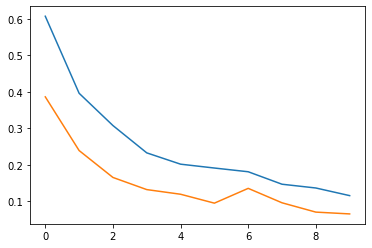

In [25]:
plt.figure()
plt.plot(np.arange(0,Epoch),history.history["loss"],label="train_loss")
plt.plot(np.arange(0,Epoch),history.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,Epoch),history.history["acc"],label="train_acc")
plt.plot(np.arange(0,Epoch),history.history["val_acc"],label="val_acc")
plt.title("Results of training")
plt.legend()
plt.show()

In [26]:
# Saving The trained model for future use
fin_mod.save("trained_mask.h5")